In [1]:
# %% imports
import torch
import torch.nn as nn
from torch.nn.modules.activation import ReLU



In [2]:
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()  # same as super().__init__()
        # how to find output shape: [input - kernel + 2*padding - (dilation-1)(kernel-1)]/stride + 1
        self.encoder = nn.Sequential(
            #  
            nn.Conv2d(1,16, kernel_size=(3,3),padding=1, stride=1), #[Nx1x32x32]=> [Nx16x32x32]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x32x32]=> [Nx16x16x16]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x16x16]=> [Nx16x16x16]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x16x16]=> [Nx16x8x8]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x8x8]=> [Nx16x8x8]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x8x8]=> [Nx16x4x4]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x4x4]=> [Nx16x4x4]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x4x4]=> [Nx16x2x2]

            nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
            nn.MaxPool2d((1,2)) #[Nx1x2x2]=> [Nx1x2x1]
        )
    def forward(self, x):
        # First branch uses dilation
        y = self.encoder(x)
        return y
    

    


In [3]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = Encoder()
test_out=model_test.forward(test_input)
print(test_out.size())

torch.Size([64, 1, 2, 1])


In [4]:
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # create layers here
            # nn.ConvTranspose2d(),
            # nn.ReLU(),
            # nn.Upsample(),
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=(3,3)), # [Nx1x2x1]=>[Nx16x4x3]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x4x3]=>[Nx16x8x6]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x8x6]=>[Nx16x10x8]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x10x8]=>[Nx16x20x16]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x10x8]=>[Nx16x22x18]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x22x18]=>[Nx16x44x36]

            nn.ConvTranspose2d(16, 1, kernel_size=(3,3)), # [Nx16x44x36]=>[Nx1x46x38]
            nn.Upsample(size=(32,32)), #[Nx1x46x38]=>[Nx1x32x32]
            )

    def forward(self, h):
        # use the created layers here
        return self.decoder(h)


In [5]:
# sanity
test_input = torch.rand(64,1,2,1)
model_test = Decoder()
test_out=model_test.forward(test_input)
print(test_out.size())

torch.Size([64, 1, 32, 32])


In [6]:
# %%  Autoencoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
#         print("Setting up the autoencoder")
#         print("We re feeding the autoencoder input of shape ", x.size())
        h = self.encoder(x)
        r = self.decoder(h)
        return r, h
    


In [7]:
# %% imports
# libraries
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# local imports
import MNIST_dataloader
import autoencoder_template
from config_file import data_loc
from matplotlib import pyplot as plt
from MNIST_dataloader import create_dataloaders


In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(torch.cuda.is_available())

import sys
print(sys.executable)

True
C:\Users\20167271\AppData\Local\Continuum\anaconda3\python.exe


In [9]:
# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
model_path = os.path.join("./", "Saved_Model.pth")

# define parameters
batch_size = 64
no_epochs = 20
learning_rate = 3e-4

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = AE()

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using ', device)
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# choose loss
criterion = nn.MSELoss(reduction='mean')


Using  cuda


In [10]:
# # %% set torches random seed
# torch.random.manual_seed(0)

# # %% preperations
# model_path = os.path.join("./", "Saved_Model.pth")

# # define parameters
# batch_size = 64
# no_epochs = 20
# learning_rate = 3e-4

# # get dataloader
# train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# # create the autoencoder
# model = AE()

# # set device
# dtype = torch.float32
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
# print('Using ', device)
# model = model.to(device=device)

# # create the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# # choose loss
# criterion = nn.MSELoss(reduction='mean')


# %% training loop
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        model.train()
        
        x_clean.to(device=device, dtype=dtype)
        label.to(device=device, dtype=dtype)
        optimizer.zero_grad()

        out, _ = model(x_clean.to(torch.device('cuda')))
        loss = criterion(out, x_clean.to(torch.device('cuda')))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_clean

            # cast the inputs to the device
            x = x.to(device=device)

            output, _ = model(x)
            loss = criterion(output, x)
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

torch.save(model.state_dict(), model_path)

  0%|          | 0/844 [00:00<?, ?it/s]

The training will start now!!!!!

Training Epoch 0:


  1%|          | 5/844 [00:00<00:17, 47.69it/s]

Epoch 0
Training Loss 0.2717043837417641
Validation Loss 0.2307068668305874

Training Epoch 1:


  1%|          | 6/844 [00:00<00:15, 52.72it/s]

Epoch 1
Training Loss 0.21080295049466227
Validation Loss 0.20689966063946486

Training Epoch 2:


  1%|          | 6/844 [00:00<00:14, 56.16it/s]

Epoch 2
Training Loss 0.19842754809353588
Validation Loss 0.20088231284171343

Training Epoch 3:


  1%|          | 6/844 [00:00<00:15, 55.13it/s]

Epoch 3
Training Loss 0.19418765537405466
Validation Loss 0.1975250095129013

Training Epoch 4:


  1%|          | 6/844 [00:00<00:15, 55.13it/s]

Epoch 4
Training Loss 0.1914744740307896
Validation Loss 0.19429442659020424

Training Epoch 5:


  1%|          | 6/844 [00:00<00:15, 55.64it/s]

Epoch 5
Training Loss 0.18891738021472618
Validation Loss 0.1931380145251751

Training Epoch 6:


  1%|          | 6/844 [00:00<00:14, 58.34it/s]

Epoch 6
Training Loss 0.18584973110830613
Validation Loss 0.18723720591515303

Training Epoch 7:


  1%|          | 6/844 [00:00<00:14, 56.72it/s]

Epoch 7
Training Loss 0.18226804494222193
Validation Loss 0.18408075626939535

Training Epoch 8:


  1%|          | 6/844 [00:00<00:14, 57.25it/s]

Epoch 8
Training Loss 0.1798350576364316
Validation Loss 0.18317420221865177

Training Epoch 9:


  1%|          | 6/844 [00:00<00:15, 55.62it/s]

Epoch 9
Training Loss 0.17798665594927507
Validation Loss 0.18066749814897776

Training Epoch 10:


  1%|          | 6/844 [00:00<00:15, 55.13it/s]

Epoch 10
Training Loss 0.17667468269995604
Validation Loss 0.17753044795244932

Training Epoch 11:


  1%|          | 5/844 [00:00<00:17, 49.09it/s]

Epoch 11
Training Loss 0.17546445475582262
Validation Loss 0.17726890835911036

Training Epoch 12:


  1%|          | 6/844 [00:00<00:14, 57.78it/s]

Epoch 12
Training Loss 0.17443895225205694
Validation Loss 0.17718174029141665

Training Epoch 13:


  1%|          | 6/844 [00:00<00:14, 57.86it/s]

Epoch 13
Training Loss 0.173448827576722
Validation Loss 0.17531140614300966

Training Epoch 14:


  1%|          | 6/844 [00:00<00:14, 56.77it/s]

Epoch 14
Training Loss 0.17253425574345047
Validation Loss 0.17629555985331535

Training Epoch 15:


  1%|          | 6/844 [00:00<00:14, 57.85it/s]

Epoch 15
Training Loss 0.17169109179298458
Validation Loss 0.17268479987978935

Training Epoch 16:


  1%|          | 6/844 [00:00<00:14, 56.23it/s]

Epoch 16
Training Loss 0.17076615874448095
Validation Loss 0.17588049545884132

Training Epoch 17:


  1%|          | 6/844 [00:00<00:14, 58.99it/s]

Epoch 17
Training Loss 0.16987813846759886
Validation Loss 0.171732310205698

Training Epoch 18:


  1%|          | 6/844 [00:00<00:14, 57.85it/s]

Epoch 18
Training Loss 0.1689580614850702
Validation Loss 0.17700039595365524

Training Epoch 19:


100%|██████████| 844/844 [00:14<00:00, 59.98it/s]


Epoch 19
Training Loss 0.16822895149907793
Validation Loss 0.17265421990305185


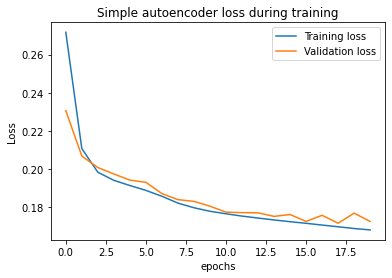

In [18]:
plt.plot(range(no_epochs), eval_dic['Loss_t'][:], label="Training loss")
plt.plot(range(no_epochs), eval_dic['Loss_v'][:], label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Simple autoencoder loss during training")
plt.legend()
plt.show()

In [14]:
len(eval_dic['Loss_t'])

20

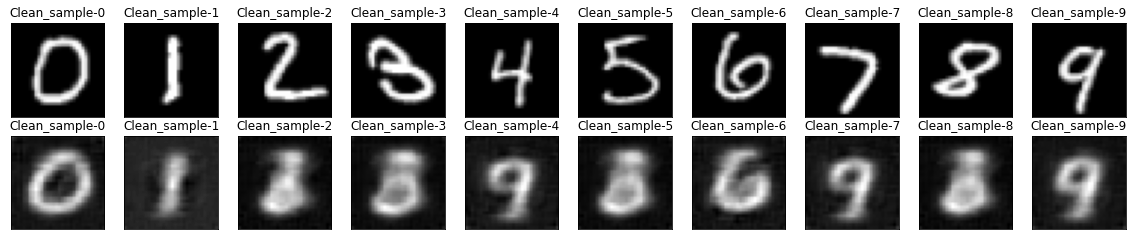

In [8]:
# %% Plot an output after training
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)


# Load in the model on CPU
device = torch.device('cpu')
model = AE()
model.load_state_dict(torch.load(model_path))
model = model.to(device=device)


with torch.no_grad():
    plt.figure(figsize=(20,10))
    output,_ = model.forward(x_clean_example)
    for i in range(10):
        example = x_clean_example[i,0,:,:]
        example_out =  output[i,0,:,:]
        plt.subplot(5,10,i+1)
        plt.gca().set_title('Clean_sample-'+str(i))
        plt.imshow(example,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(5,10,i+11)
        plt.gca().set_title('Clean_sample-'+str(i))
        plt.imshow(example_out,cmap='gray')
        plt.xticks([])
        plt.yticks([])


# %% HINT
# #hint: if you do not care about going over the data in mini-batches but rather want the entire dataset use:
# x_clean_train = train_loader.dataset.Clean_Images
# x_noisy_train = train_loader.dataset.Noisy_Images
# labels_train  = train_loader.dataset.Labels

# x_clean_test  = test_loader.dataset.Clean_Images
# x_noisy_test  = test_loader.dataset.Noisy_Images
# labels_test   = test_loader.dataset.Labels

# # use these 10 examples as representations for all digits
# x_clean_example = x_clean_test[0:10,:,:,:]
# x_noisy_example = x_noisy_test[0:10,:,:,:]
# labels_example = labels_test[0:10]

In [ ]:
# ####### TRAINING

# # Paramters
# batch_size = 64
# epochs = 10
# device =
# # get dataloader
# train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# # get some examples
# examples = enumerate(test_loader)
# _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# y_output = Encoder().forward(x_clean_example)
# print(y_output)

# # Test if the encoder works
# if __name__ == "__main__":
#     # imports and parameters
#     from config_file import data_loc
#     import MNIST_dataloader
#     import autoencoder_template
#     from matplotlib import pyplot as plt
#     from MNIST_dataloader import create_dataloaders
#     batch_size = 64
    
#     # get dataloader
#     train_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
#     # get some examples
#     examples = enumerate(test_loader)
#     _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
#     y_output = Encoder().forward(x_clean_example)
#     # try out the model before any training
#     model = AE()
#     output = model.forward(x_noisy_example)
#     plt.figure(figsize=(12,3))
#     plt.imshow(x_clean_example[0,0,:,:],cmap='gray')
#     plt.show()

# Exercise 2

In [ ]:
from config_file import data_loc
from MNIST_dataloader import *
import matplotlib.cm as cm
import numpy as np

In [9]:
######################  Get the data  ##################################
# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = AE()
model_path = os.path.join("./", "Saved_Model.pth")
model.load_state_dict(torch.load(model_path))
# batch_size = 64
######### DEF PLOTTING LATENT
# model(x_clean.to(torch.device('cuda')))
# for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
def latent_plot(model, data, batch_size=64):
    # put the model in the correct device!
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)
    
    # make a rainbow_color space for the 10 classes
    color_list = cm.rainbow(np.linspace(0, 1, 10))
    k = 0
    for i, (x, y, label) in enumerate(data):
        # get the latent space from the encoder
        z = model.encoder(x.to(torch.device('cuda')))
        z = z.to(torch.device('cpu')).detach().numpy()
#         if i == 0: # for sanity check!!!!
        for j in range(len(z)):
#                 print(z[j][0][0],z[j][0][1],label[j].item())
#                 print(z[:,:,0])
            plt.scatter(z[:,:,0],z[:,:,1], c=label[:], cmap='tab10')
        if i == len(data)-1:
            print(len(z))
            plt.colorbar()
            break



#                 plt.scatter(z[:][0][0],z[:][0][1], color = color_list[label[:]])
#                 plt.annotate(label[j].item(),(z[j][0][0],z[j][0][1]))
    #             plt.annotate(label[j].item(), (z[j][0][0], z[j][0][1]), 
    #                          color = color_list[labels_example[j]],
    #                          fontsize= 30 )
    # #             print(z.flatten())
    # #             plt.scatter(z[i][0][0][0], z[i][0][0][1], c=label[:], cmap='tab10')
    # #         if i > num_batches:
    # #             plt.colorbar()
    # #             break



In [ ]:
plt.figure(figsize=(20,10))
latent_plot(model, test_loader)
plt.xlabel(' Horizontal')
plt.ylabel(' Vertical')
# plt.xlim((0,1))
# plt.ylim((0,1))
plt.grid()

In [ ]:
# latent_plot(model, test_loader)


In [ ]:
# get dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9
# make some fake encoder [1x2] outputs of batchsize
x = torch.rand(batch_size,1,2,1)

# X = x[image_number][0][0], Y =  x[image_number][0][1],  label = labels[image_number]

# make a rainbow_color space for the 10 classes
color_list = cm.rainbow(np.linspace(0, 1, 10))

# Plot the latent space
plt.figure(figsize=(20,20))
for i in range(batch_size):
    # plt.scatter(x[i][0][0],x[i][0][1], 
    #             color = color_list[labels_example[i]],
    #             linewidths= 5) 
    plt.annotate(labels_example[i].item(), (x[i][0][0], x[i][0][1]), 
                color = color_list[labels_example[i]],
                fontsize= 30 )
plt.xlabel(' Horizontal')
plt.ylabel(' Vertical')
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()

# Exercise 3
### (a) [2 pt]  Encode the test data x_clean_test and perform a 1-nearest neighbour search. 
You can use the sci-kit learn library for nearest neighbour implementations: from sklearn.neighbors import NearestNeighbors In the 1-nearest neighbour, for every datapoint in the latent space of the testset, you search the datapoint from the training set that has the smallest Euclidean distance in the latent space. You can consider this such that the two images are mapped to the same area in the latent space and hence have relatively high probability that their characteristics, hopefully the digits they represent, are similar. Therefore, assign the class to the test image that corresponds with the class labels_train of its nearest neighbour.

In [10]:
import sklearn
from sklearn.neighbors import NearestNeighbors
import numpy as np

############################### TEST SETUP ##############################################
# make some fake encoder [1x2] outputs of batchsize
x = torch.rand(batch_size,1,2,1)
xq3 = x.flatten(start_dim=1).numpy()
# print(xq3)


samples = [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
# X3_lol = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# 
# neigh = NearestNeighbors(n_neighbors=1, radius=2.0)
# neigh.fit(X3_lol)
# dist, indi = neigh.kneighbors(X3_lol)


nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(samples)
distances, indices = nbrs.kneighbors(samples)
print(indices)
print(distances)

samples = [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
# X3_lol = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# 
# neigh = NearestNeighbors(n_neighbors=1, radius=2.0)
# neigh.fit(X3_lol)
# dist, indi = neigh.kneighbors(X3_lol)


nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(samples)
distances, indices = nbrs.kneighbors(samples)
print(indices)
print(distances)


[[0 2]
 [1 2]
 [2 0]]
[[0.         1.        ]
 [0.         1.41421356]
 [0.         1.        ]]
[[0 2]
 [1 2]
 [2 0]]
[[0.         1.        ]
 [0.         1.41421356]
 [0.         1.        ]]


In [20]:
###### LOAD IN THE DATA ####################

# %% HINT
#hint: if you do not care about going over the data in mini-batches but rather want the entire dataset use:
# x_clean_train = train_loader.dataset.Clean_Images
# x_noisy_train = train_loader.dataset.Noisy_Images
# labels_train  = train_loader.dataset.Labels

# x_clean_test  = test_loader.dataset.Clean_Images
# x_noisy_test  = test_loader.dataset.Noisy_Images
# labels_test   = test_loader.dataset.Labels

# # use these 10 examples as representations for all digits
# x_clean_example = x_clean_test[0:10,:,:,:]
# x_noisy_example = x_noisy_test[0:00,:,:,:]
# labels_example = labels_test[0:100]


#hint: if you do not care about going over the data in mini-batches but rather want the entire dataset use:
x_clean_train = train_loader.dataset.Clean_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
# x_clean_Q3 = x_clean_test[0:10,:,:,:]
# labels_example = labels_test[0:10]



    
    



In [12]:
from sklearn.neighbors import NearestNeighbors
# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)


# init paramters
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# create the autoencoder and load in saved model
model = AE()
model_path = os.path.join("./", "Saved_Model.pth")
model.load_state_dict(torch.load(model_path))
model = model.to(device=device)
model.eval()


AE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (decoder): Decoder(
    (decoder): S

In [13]:
x_clean_test_Q3 = x_clean_test[0:1000,:,:,:]

with torch.no_grad():
    _,enc_train = model(x_clean_train.to(device=device, dtype=dtype)) 
    _,enc_test = model(x_clean_test_Q3.to(device=device, dtype=dtype))


In [14]:
print(enc_test.size()) #[1000,1,2,1]
print(enc_train.size()) #[54000,1,2,1]


#### convert back to cpu and squeeze dimensions from [Nx1x2x1] => [Nx2]
enc_train = enc_train.cpu().detach().numpy().squeeze()
enc_test = enc_test.cpu().detach().numpy().squeeze()



torch.Size([1000, 1, 2, 1])
torch.Size([54000, 1, 2, 1])


[[-13.115855  -10.32504  ]
 [ -7.0695114 -11.490951 ]
 [-17.695007   -5.622559 ]
 ...
 [ -9.928099  -10.94212  ]
 [-14.236233   -8.959322 ]
 [-11.356438  -11.911134 ]]


([<matplotlib.axis.XTick at 0x272e7a5e280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

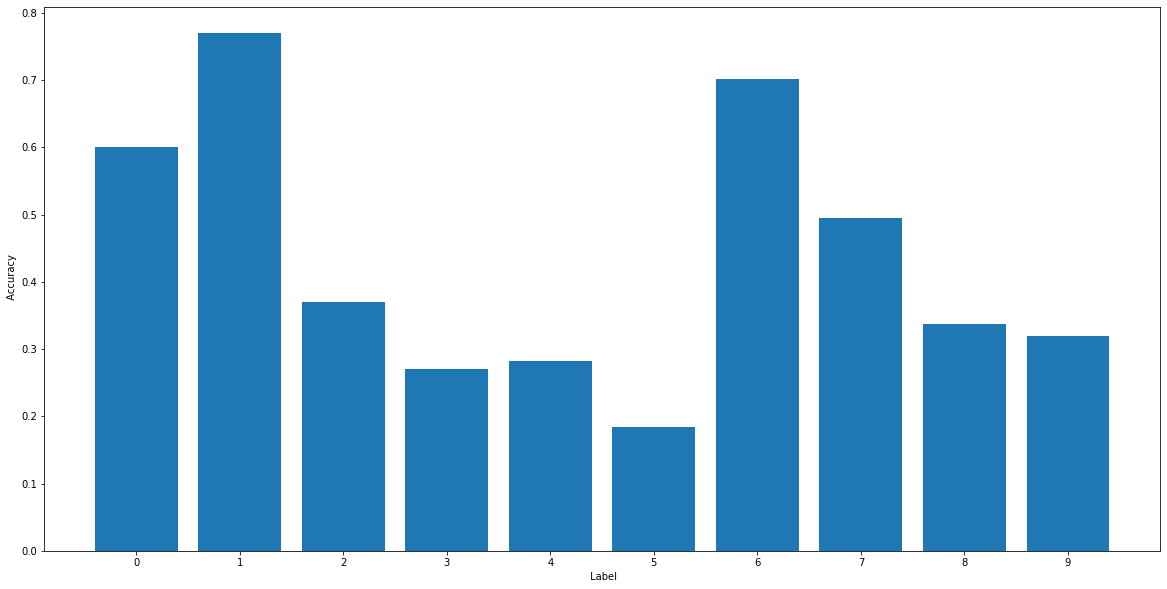

In [83]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(enc_train)
distances, indices = nbrs.kneighbors(enc_test)

# get the labels from the corresponding training labels
labels_test_pred = labels_train[indices].squeeze()

plt.figure(figsize=(20,10))
acc = []
for i in range(10):
    # get the amount of cells in pred_labels which equal == i
    #  get the amount of cells in true_labels which equal == i
    # sum these values
    # divide

    pred_sum = (labels_test_pred == i).long() # get boolean and convert to [1 0] Truth-mask
    truth_sum = (labels_test[0:1000] == i).long() # get a boolean mask and convert it to [1 0]
    mask_sum = pred_sum+truth_sum
    mask_sum2 = (mask_sum>1).long() # basically if a value is bigger than 1 it means that both the prediction and truth are the same for that indice
    accuracy = torch.divide(mask_sum2.sum(), truth_sum.sum()) # we didivde sum(predicted_that_where_correct)/sum(all_correct)
    acc.append(accuracy.item())

langs = range(0,10)
plt.bar(langs, acc)
plt.xlabel(' Label')
plt.ylabel(' Accuracy')
plt.xticks(langs)


### (b) [1 pt]If the classification based on the latent space would not work at all and produce random datapoint in the latent space, how many correct classifications would you expect? 
Which numbers are classified significantly better than the other, and
(consequently) which number aren’t? Can you explain this from the plot of the latent
space you made in Exercise 2?

The number 1 and 6 are the highest, going a bit down in accuracy are the number 0 and 7 but still higher than 0.5 (i.e. random chance). It seems the numbers between 2 till and including 5 perform the worst. 
# Complete the answer!

### (c) [0.5 pt]If we would design our network differently, where our goal would not be to encode and decode the images but to correctly classify the images, what cost function would you use?

# Exercise 4
### As mentioned above, the autoencoder is not designed for classification, but still it manages to classify at least some of the digits relatively accurately. With a rather simple modification, it should be possible to convert your network into a network that is designed for classification purposes.

That depends on the amount of classes one has to classify. If it is two, Binary Cross Entropy would be a good loss function. If we have more than 2 classes than you need the Categorical Cross Entropy Loss

### (a) [2 pt]Use your Encoder as starting point and replace the last Convolutional layer (andits associated Activation and Pooling layer) and replace these by a Fully-Connected,or its equivalent: Dense, layer. 
If necessary, you can use a Flatten and Activation layer
as well. Assign a proper loss function and train and test your network on exactly the
same training and test data. What accuracies on the test set can you achieve now?

In [2]:
# %%  Encoder
class EncoderQ4(nn.Module):
    def __init__(self):
        super(EncoderQ4, self).__init__()  # same as super().__init__()
        # how to find output shape: [input - kernel + 2*padding - (dilation-1)(kernel-1)]/stride + 1
        self.encoder = nn.Sequential(
            #  
            nn.Conv2d(1,16, kernel_size=(3,3),padding=1, stride=1), #[Nx1x32x32]=> [Nx16x32x32]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x32x32]=> [Nx16x16x16]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x16x16]=> [Nx16x16x16]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x16x16]=> [Nx16x8x8]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x8x8]=> [Nx16x8x8]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x8x8]=> [Nx16x4x4]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x4x4]=> [Nx16x4x4]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x4x4]=> [Nx16x2x2]

#             nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
#             nn.MaxPool2d((1,2)) #[Nx1x2x2]=> [Nx1x2x1]
            nn.Flatten(), #[Nx16x2x2] => [Nx64]
            nn.LogSoftmax(dim=1) # dim=1 and NOT 0 because you dont want to get log(prob) over the batches
        )
    def forward(self, x):
        # First branch uses dilation
        y = self.encoder(x)
        return y

NameError: name 'nn' is not defined

In [98]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = EncoderQ4()
test_out=model_test.forward(test_input)
print(test_out.size())

torch.Size([64, 64])


In [105]:
# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
model_path = os.path.join("./", "Saved_ModelQ4.pth")

# define parameters
batch_size = 64
no_epochs = 20
learning_rate = 3e-4

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the classification encoder
model = EncoderQ4()

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using ', device)
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# choose loss
criterion = torch.nn.CrossEntropyLoss()





Using  cuda:0


In [3]:
# %% training loop
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        model.train()
        
        x_clean =x_clean.to(device=device, dtype=dtype)
#         print(x_clean)
        
        label = label.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()

        out = model(x_clean)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_clean

            # cast the inputs to the device
            x = x.to(device=device)
            label = labels.to(device=device, dtype=torch.int64)
            
            output = model(x)
            
            loss = criterion(output, label)
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

torch.save(model.state_dict(), model_path)

The training will start now!!!!!


NameError: name 'no_epochs' is not defined

EncoderQ4(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LogSoftmax(dim=1)
  )
)

In [158]:
model = EncoderQ4()
model_path = os.path.join("./", "Saved_ModelQ4.pth")
model.load_state_dict(torch.load(model_path))
model = model.to(device=device)
model.eval()
for i in range(10):
    # get the amount of cells in pred_labels which equal == i
    #  get the amount of cells in true_labels which equal == i
    # sum these values
    # divide

    pred_sum = (labels_test_pred == i).long() # get boolean and convert to [1 0] Truth-mask
    truth_sum = (labels_test[0:1000] == i).long() # get a boolean mask and convert it to [1 0]
    mask_sum = pred_sum+truth_sum
    mask_sum2 = (mask_sum>1).long() # basically if a value is bigger than 1 it means that both the prediction and truth are the same for that indice
    accuracy = torch.divide(mask_sum2.sum(), truth_sum.sum()) # we didivde sum(predicted_that_where_correct)/sum(all_correct)
    acc.append(accuracy.item())
#### Accuracy on test
pred_test_Q4 =x_clean_test[0:1000,:,:,:]
pred_test_Q4 = pred_test_Q4.to(device=device, dtype=dtype)

# get the ground truth labels
gt_Q4 = labels_test[0:1000]

with torch.no_grad():
    #Get the probs on the test set
    pred_label_Q4 = model(pred_test_Q4).cpu().detach() #[1000x64]
    
    
    

In [169]:
# print(len(pred_label_Q4[999]))
_,max_value_index = torch.max(pred_label_Q4,dim=1)
# print(max_value_index )
for i in range(1):
    a = (max_value_index == gt_Q4).long().float()
    acc =  torch.mean(a).item()
print('The accuracy is: ', acc)

The accuracy is:  0.9710000157356262


### (b) [1 pt]Provide graphs of the training and test loss (perform intermittent evaluationsof the test loss during training). 
Comment on the capacity of your network.

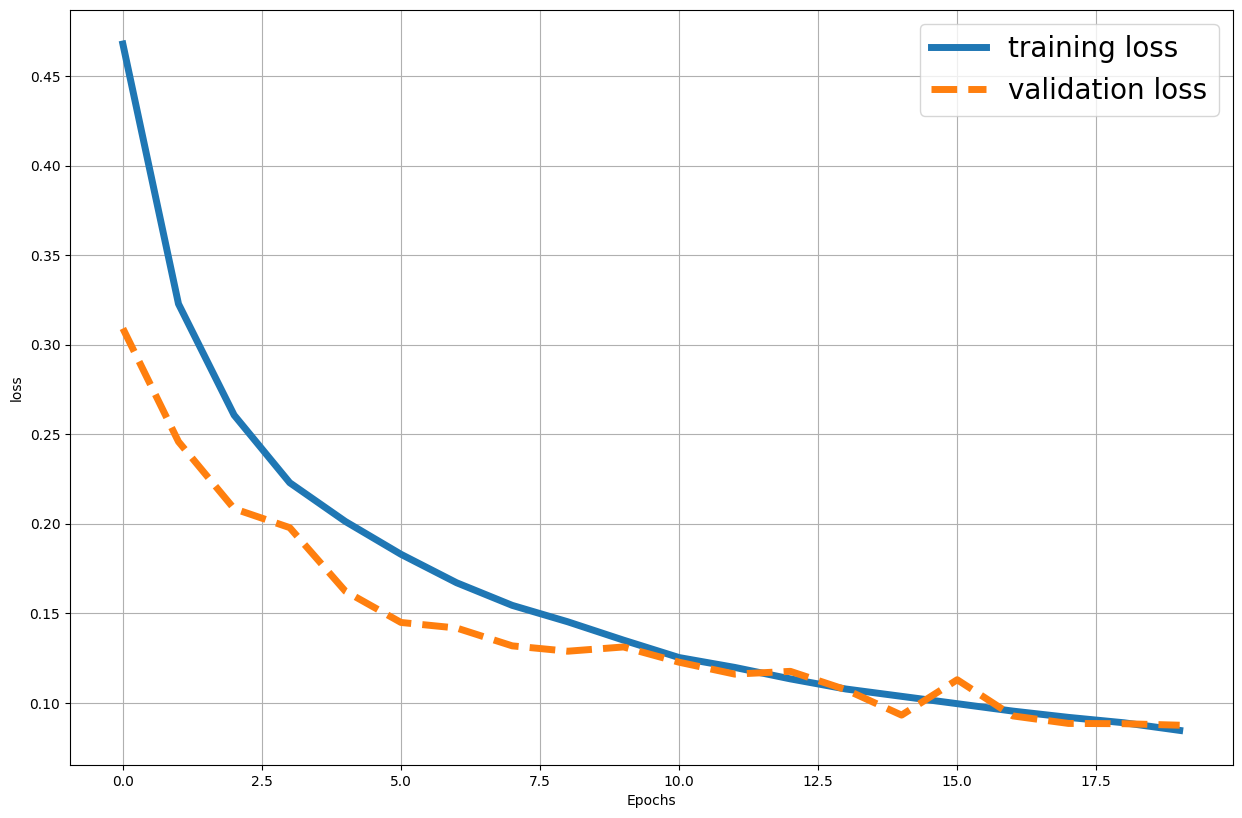

In [194]:
plt.figure(figsize=(15,10),dpi=100)
plt.plot(range(no_epochs), eval_dic['Loss_t'], 
         label='training loss', linewidth=5)
plt.plot(range(no_epochs), eval_dic['Loss_v'], 
         label='validation loss', linestyle='--', linewidth=5)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=0, prop={'size': 20})
# plt.

# Exercise 5
### In this exercise you are going to use your previously trained autoencoder – in particular the Decoder stage – as a generative model.

### a) [2 pt]Define a 15 x 15 grid that equidistantly samples the latent space of Exercise2 across both axes. 
In other words, if you visualize the latent space as a Cartesian coordinate system, sample between the points that describe the corners of your (cubicshaped) latent space. Use 15 steps in both horizontal and vertical directions.